# Coherent error models


## basic calculation

Let's say we want to play an -Y/2 gate and we have an error of $\epsilon\ll 1$ so that our rotation axis is not $-\hat{y}$ but $-\sqrt{1-\epsilon^2}\hat{y} + \epsilon\hat{x}$. What is the error associated with this?

The unitary is: 

$$
U_e = \frac{1}{\sqrt{2}}I - i\frac{1}{\sqrt{2}}(\sqrt{1-\epsilon^2}\sigma_y + \epsilon\sigma_x)
$$

We want to calculate $F(|+>, U_e|0>) = |<+|U_e|0>|$. This is:

$$
U_e|0> = \frac{1}{\sqrt{2}}|0>+\frac{1}{\sqrt{2}}(\sqrt{1-\epsilon^2}|1>-i\epsilon|1>) \\
 \Rightarrow |<+|U_e|0>| = \frac{1}{2}|1 + \sqrt{1-\epsilon^2}-i\epsilon| \\
 = \sqrt{\frac{1}{2} + \frac{1}{2} \sqrt{1-\epsilon^2}} \\
 \simeq 1 -\frac{1}{8}\epsilon^2
$$

so we see that the error is of order $\epsilon^2$.

Let's verify this:

In [143]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline
plt.rcParams.update({'text.usetex': False})

In [2]:

err_u = lambda epsilon: qp.qip.operations.rotation(np.sqrt(1-epsilon**2)*qp.sigmay()+qp.sigmax()*epsilon, 
            np.pi/2)


In [3]:
def fidelity_err(epsilon):
    return np.abs(((1/np.sqrt(2))*(qp.bra([0]) + qp.bra([1]))*err_u(epsilon)*qp.fock(2, 0))[0])

fidelity_err = np.vectorize(fidelity_err)

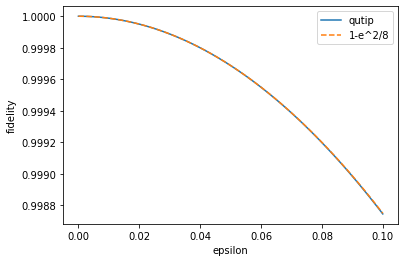

In [144]:

eps_vec = np.linspace(0, 0.1, 100)
plt.plot(eps_vec, fidelity_err(eps_vec), label='qutip')
plt.plot(eps_vec, 1-eps_vec**2/8, '--', label='1-e^2/8')
plt.xlabel('epsilon')
plt.ylabel('fidelity')
plt.legend()

## RB simulation with qiskit



In [17]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error, coherent_unitary_error

In [81]:
qiskit.circuit.library.SXGate().to_matrix()
sx_gate_u2.to_matrix()

array([[ 0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j],
       [ 0.70710678+0.00000000e+00j, -0.70710678+8.65956056e-17j]])

In [136]:
be_unitary = qiskit.Aer.get_backend('unitary_simulator')

be_aer = qiskit.Aer.get_backend('aer_simulator')


sy_gate = qiskit.circuit.library.RYGate(np.pi/2)
sydg_gate = qiskit.circuit.library.RYGate(-np.pi/2)
sx_gate = qiskit.circuit.library.RXGate(np.pi/2)
sxdg_gate = qiskit.circuit.library.RXGate(-np.pi/2)

circ = QuantumCircuit(1, 1)
circ.sx(0)
circ.append(sxdg_gate, [0])
circ.append(sxdg_gate, [0])
circ.append(sxdg_gate, [0])
circ.append(sxdg_gate, [0])
circ.append(sxdg_gate, [0])

print(circ.draw())
job = be_unitary.run(circ,
                 noise_model=noise_model)
print(np.around(job.result().get_unitary(), 3))

#circ.measure(0, 0)



def qiskit_u_err(epsilon, nshots=100000):
    z_rot = qiskit.circuit.library.U1Gate(epsilon)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(coherent_unitary_error(z_rot), 'sx')

    circ.measure(0, 0)
    job = be_aer.run(assemble(circ, shots=nshots),
                      noise_model=noise_model)
    return job.result().get_counts()['0']/nshots

     ┌────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐
q_0: ┤ √X ├┤ Rx(-π/2) ├┤ Rx(-π/2) ├┤ Rx(-π/2) ├┤ Rx(-π/2) ├┤ Rx(-π/2) ├
     └────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘
c: 1/══════════════════════════════════════════════════════════════════
                                                                       
[[-0.707-0.707j -0.   +0.j   ]
 [-0.   +0.j    -0.707-0.707j]]


In [137]:
error_model = [qiskit_u_err(eps) for eps in eps_vec]

Text(0.5, 1.0, 'qiskit simulation of initial phase error')

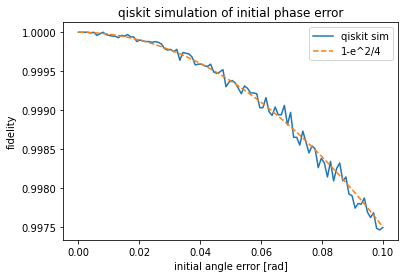

In [147]:
plt.plot(eps_vec, error_model, label='qiskit sim')
plt.plot(eps_vec, 1-eps_vec**2/4, '--', label='1-e^2/4')
plt.xlabel('initial angle error [rad]')
plt.ylabel('fidelity')
plt.legend()
plt.title('qiskit simulation of initial phase error')

In [ ]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')



backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))